In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn
sn.set_style("whitegrid")

import inputs
import models
import shooting

import operator
from scipy.interpolate import interp1d

from __future__ import division

# Calibrating the Adamopoulos and Restuccia(2014) paper with $x$, exponential version

This notebook solves for a model with two-sided heterogeneity and firm size when capital also enters the production function.

In particular, the production function takes the form:

$$F(x,y,l,r,k) = rA\kappa ( k^{\rho} \eta + (1-\eta) (y(l/r)^{x})^{\rho})^{\gamma/\rho}$$

The solution for optimal capital ($k^{*}(x,y,l,r)$) can be found in the New Capital.ipynb notebook.

First, workers and firms are created - we assume worker skill is very homogeneous, and that firm skill follows a lognormal distribution.

Then the model is solved for Rich ($A=1,R=0.13099$) and Poor ($A=0.5105,R=0.83684$) countries and then comapres the solution.

In [135]:
# define some workers skill
x, a, b = sym.var('x, a, b')
skill_cdf = ((x - a) / (b - a))
skill_params = {'a': 0.999, 'b': 1.001}
skill_bounds = [skill_params['a'], skill_params['b']]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some firms lognorm.pdf(x, s) = 1 / (s*x*sqrt(2*pi)) * exp(-1/2*(log(x)/s)**2)
y, loc2, mu2, sigma2 = sym.var('y, loc2, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y - loc2) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'loc2': 1e0, 'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = (1.2, 1e1)

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

## 1.Solving for the Rich Country

In [137]:
# Developped country

R, l, r, rho, gamma, eta, L, A, kapa = sym.var('R, l, r, rho, gamma, eta, L, A, kapa')

# First set k to the optimum (look at Capital notebook)
k_star = (2*6**(-0.5)*(r*A*eta**2*kapa/R)**0.5*sym.cos(0.333333333333333*sym.acos(3*6**0.5*((l/r)**x*y)**0.25*(R/(r*A*eta**2*kapa))**0.5*(-eta + 1)/(2*eta))))**(4)

F = r*A*kapa*(eta*(k_star)**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)

F_params = {'R':0.13099, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':4.2, 'A': 1.0, 'kapa':1.0}

In [138]:
model = models.Model(assortativity='positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

In [139]:
solver.solve(100.0, tol=1e-6, number_knots=1000, knots=None, integrator='lsoda', message=False)

Success! All workers and firms are matched


In [140]:
solver.solution

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.999000,1.199999,0.923223,0.151982,2.797551
0.999002,1.201978,0.923563,0.152008,2.797759
0.999004,1.203944,0.923900,0.152034,2.797965
0.999006,1.205899,0.924235,0.152060,2.798169
0.999008,1.207842,0.924567,0.152085,2.798372
0.999010,1.209774,0.924897,0.152110,2.798574
0.999012,1.211695,0.925225,0.152135,2.798774
0.999014,1.213606,0.925551,0.152160,2.798973
0.999016,1.215508,0.925875,0.152185,2.799171


In [141]:
sol1 = solver.solution
xs = sol1.index.values
ys = sol1['$\\mu(x)$'].values
thetas = sol1['$\\theta(x)$'].values
ws = sol1['$w(x)$'].values

# For capital lambdify k_star
eval_k = sym.lambdify((x,y,l,r,A,kapa,eta,R), k_star)
ks = []
for a in range(len(xs)):
    ks.append(eval_k(xs[a],ys[a],thetas[a],1,1,1,0.89,0.13099))
ks = np.array(ks)

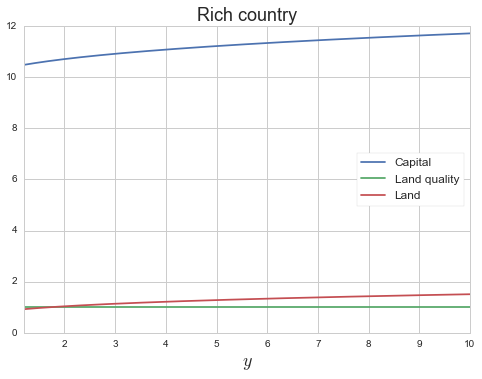

In [142]:
# Plotting the solution
plt.plot(ys, ks, label="Capital")
plt.plot(ys, xs, label="Land quality")
plt.plot(ys, thetas, label="Land")
plt.legend(loc='best', frameon=True, fontsize=12)
plt.xlim(min(ys), max(ys))
plt.xlabel('$y$', fontsize=18)
plt.title("Rich country", fontsize=18)
plt.show()

In [143]:
def pdf_workers(xs):
    return np.ones(len(xs))*(4.2/len(xs))

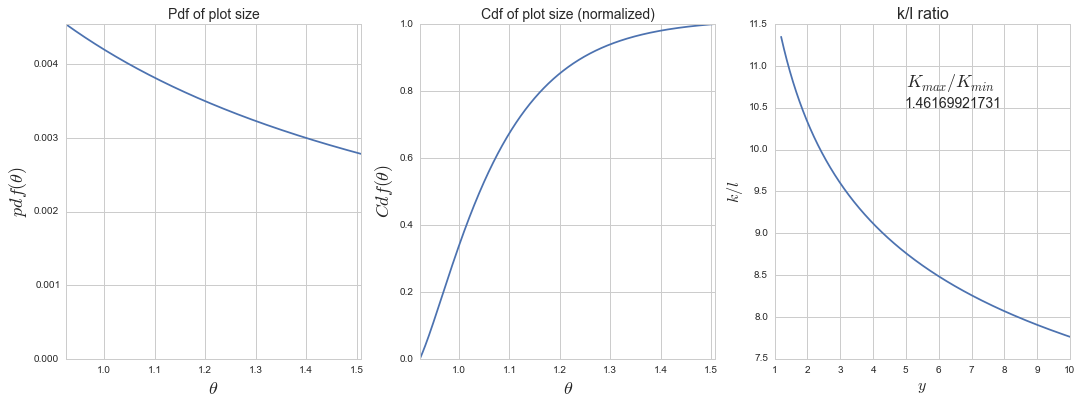

In [144]:
# # # # Firm size distribution # # # # 
pdf_theta_hat = pdf_workers(xs)/thetas

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(thetas,pdf_theta_hat)
plt.ylabel('$pdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.xlim(min(thetas), max(thetas))
plt.title('Pdf of plot size', fontsize=14)
plt.ylim(0,max(pdf_theta_hat))

plt.subplot(1,3,2)
cdf_theta_hat = np.cumsum(pdf_theta_hat)/sum(pdf_theta_hat)
plt.plot(thetas,cdf_theta_hat)
plt.ylabel('$Cdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.title('Cdf of plot size (normalized)', fontsize=14)
plt.xlim(min(thetas), max(thetas))

k_ratio = ks/thetas
plt.subplot(1,3,3)
plt.plot(ys,k_ratio)
plt.xlabel('$y$', size=16)
plt.ylabel('$k/l$', fontsize=16)
plt.title('k/l ratio', fontsize=16)
plt.annotate(str(max(k_ratio)/min(k_ratio)), (5,10.5), fontsize=14)
plt.annotate('$K_{max}/K_{min}$', (5,10.75), fontsize=18)

plt.show()

## 2.Solving for the Poor Country

***k_star2*** is taken from *Finding k_star*, and it's an approximation to the real function for the parameters of the poor country having $x=1$. This is (I think) a fairly good approximation to the real function.

***Note: I have to check that this approxiamtion is also good for other ranges of x***

In [145]:
F_params2 = {'R':0.83684, 'rho':0.25, 'gamma':0.5, 'eta':0.89, 'L':5.46, 'A': 0.5105, 'kapa':1.0}


k_star2 = 9.17588411e-02 + -2.54383863e-03*y + 1.19799197e-04*y**2+ -2.49007510e-03*l + 1.69210383e-04*l**2 + 9.42861430e-04*y*l + -5.05040007e-05*y*l**2 + -3.91915926e-05*y**2*l + 2.10570303e-06*y**2*l**2 + 1.01634440e-02*sym.log(y) + 1.00022516e-02*sym.log(l) + 1.23659060e-03*sym.log(y)**2 + 7.89111306e-04*sym.log(l)**2 

eval_k2 = sym.lambdify((y,l), k_star2)

F2 = r*A*kapa*(eta*(k_star2)**rho + (1- eta)*(((l/r)**x)*y)**rho)**(gamma/rho)


model2 = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F2,
                     params=F_params2)

solver = shooting.ShootingSolver(model=model2)

In [147]:
solver.solve(10.0, tol=1e-6, number_knots=1000, knots=None, integrator='lsoda', message=False)

Success! All workers and firms are matched


In [148]:
solver.solution

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.999000,1.200000,0.840879,0.028546,0.156683
0.999002,1.202172,0.841359,0.028546,0.156726
0.999004,1.204328,0.841836,0.028546,0.156769
0.999006,1.206470,0.842309,0.028547,0.156812
0.999008,1.208598,0.842779,0.028547,0.156854
0.999010,1.210712,0.843245,0.028547,0.156896
0.999012,1.212814,0.843708,0.028548,0.156937
0.999014,1.214903,0.844168,0.028548,0.156978
0.999016,1.216980,0.844626,0.028548,0.157019


In [149]:
sol2 = solver.solution

xs2 = sol2.index.values
ys2 = sol2['$\\mu(x)$'].values
thetas2 = sol2['$\\theta(x)$'].values
ws2 = sol2['$w(x)$'].values

ks2 = []
for a in range(len(xs2)):
    ks2.append(eval_k2(ys2[a],thetas2[a]))
ks2 = np.array(ks2)

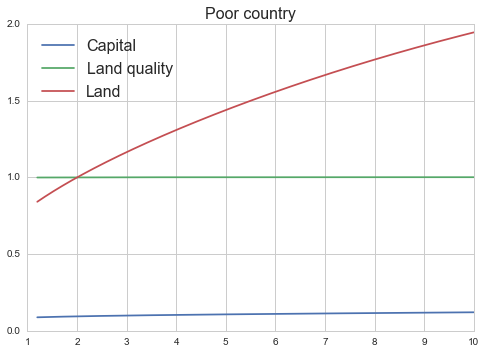

In [150]:
plt.plot(ys2, ks2, label="Capital")
plt.plot(ys2, xs2, label="Land quality")
plt.plot(ys2, thetas2, label="Land")
plt.legend(loc='best', fontsize=16)
plt.title("Poor country", fontsize=16)
plt.show()

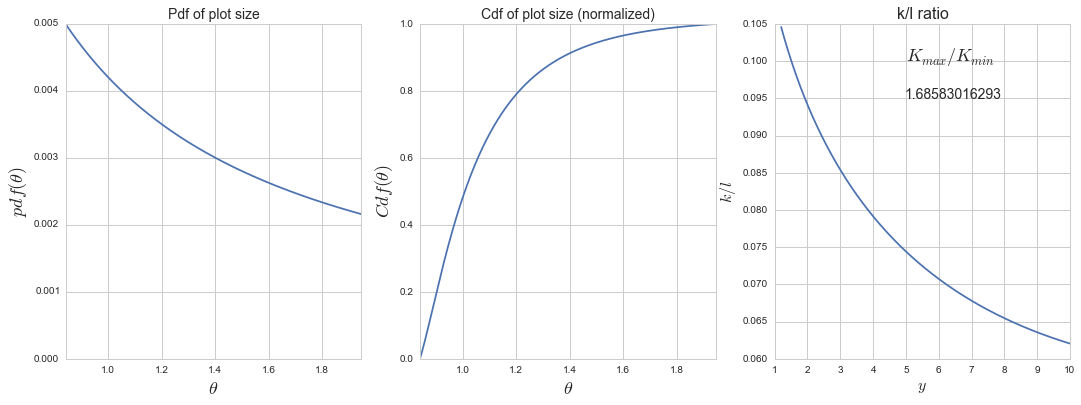

In [151]:
# # # # Firm size distribution # # # # 
pdf_theta_hat2 = pdf_workers(xs2)/thetas2

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(thetas2,pdf_theta_hat2)
plt.ylabel('$pdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.xlim(min(thetas2), max(thetas2))
plt.title('Pdf of plot size', fontsize=14)
plt.ylim(0,max(pdf_theta_hat2))

plt.subplot(1,3,2)
cdf_theta_hat2 = np.cumsum(pdf_theta_hat2)/sum(pdf_theta_hat2)
plt.plot(thetas2,cdf_theta_hat2)
plt.ylabel('$Cdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.title('Cdf of plot size (normalized)', fontsize=14)
plt.xlim(min(thetas2), max(thetas2))

k_ratio2 = ks2/thetas2
plt.subplot(1,3,3)
plt.plot(ys2,k_ratio2)
plt.xlabel('$y$', size=16)
plt.ylabel('$k/l$', fontsize=16)
plt.title('k/l ratio', fontsize=16)
plt.annotate(str(max(k_ratio2)/min(k_ratio2)), (5,0.095), fontsize=14)
plt.annotate('$K_{max}/K_{min}$', (5,0.1), fontsize=18)

plt.show()

## 3. Comparing Solutions

### All graphs have in the horizontal axis *farmer skill* ($y$)

Solutions

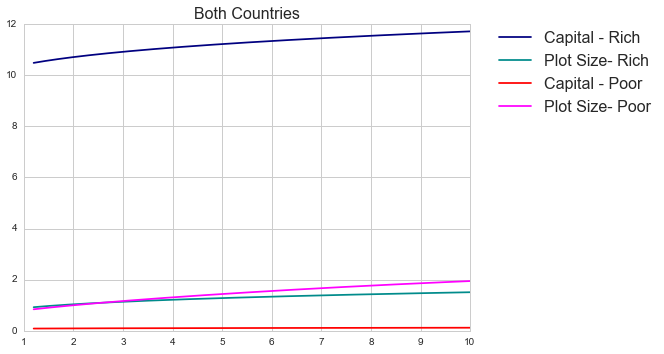

In [152]:
plt.plot(ys, ks, label="Capital - Rich", color='navy')
plt.plot(ys, thetas, label="Plot Size- Rich", color='darkcyan')
plt.plot(ys2, ks2, label="Capital - Poor", color='red')
plt.plot(ys2, thetas2, label="Plot Size- Poor", color='magenta')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., fontsize=16)
plt.title("Both Countries", fontsize=16)
plt.show()

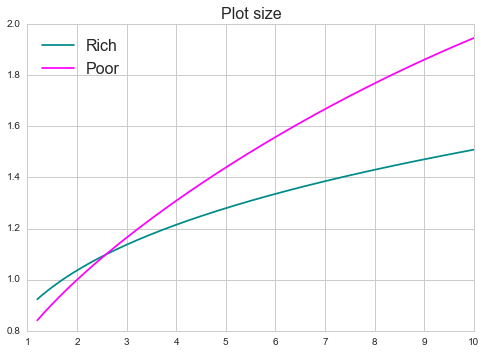

In [153]:
plt.plot(ys, thetas, label="Rich", color='darkcyan')
plt.plot(ys2, thetas2, label="Poor", color='magenta')
plt.legend(loc='best', fontsize=16)
plt.title("Plot size", fontsize=16)
plt.show()

Land quality ($x$)

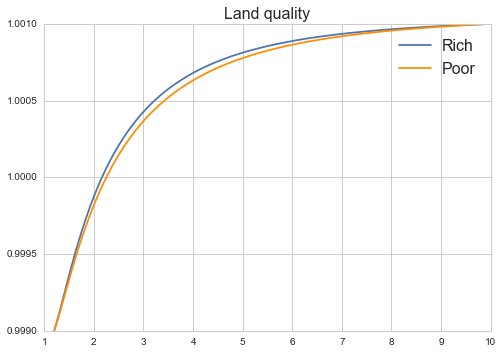

In [154]:
plt.plot(ys, xs, label="Rich")
plt.plot(ys2, xs2, label="Poor", color='darkorange')
plt.legend(loc=1, fontsize=16)
plt.title("Land quality", fontsize=16)
plt.show()

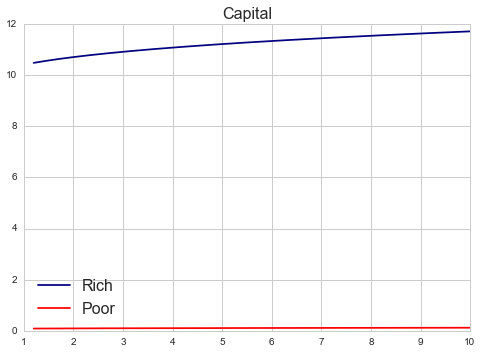

In [155]:
plt.plot(ys, ks, label="Rich", color='navy')
plt.plot(ys2, ks2, label="Poor", color='red')
plt.legend(loc='best', fontsize=16)
plt.title("Capital", fontsize=16)
plt.show()

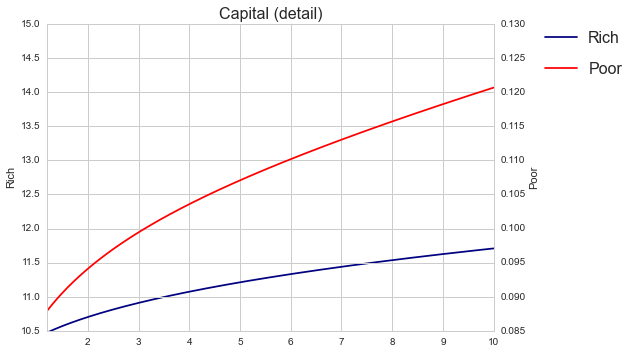

In [156]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Rich')
ax1.set_ylim(10.5,15,0.5)
plt.plot(ys, ks, label="Rich", color='navy')
plt.xlim(min(ys),max(ys))

ax2 = ax1.twinx()
plt.plot(ys2, ks2, label="Poor", c='red')
ax2.set_ylabel('Poor')
ax2.set_ylim(0.085,0.13)

ax1.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0., fontsize=16)
ax2.legend(bbox_to_anchor=(1.065, 0.95), loc=2, borderaxespad=1, fontsize=16)
plt.xlim(min(ys),max(ys))
plt.title("Capital (detail)", fontsize=16)
plt.show()

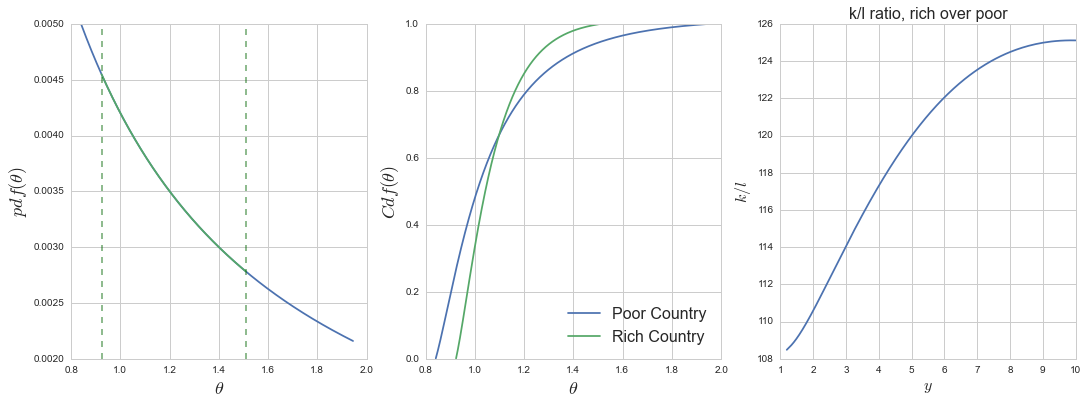

In [162]:
# # # # Firm size distribution # # # # 

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(thetas2,pdf_theta_hat2)
plt.plot(thetas,pdf_theta_hat)
plt.ylabel('$pdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.axvline(min(thetas), alpha=0.5, color='darkgreen',  linestyle='--')
plt.axvline(max(thetas), alpha=0.5, color='darkgreen',  linestyle='--')
#plt.xlim(min(thetas2), max(thetas2))
#plt.ylim(0,max(pdf_theta_hat2))

plt.subplot(1,3,2)
plt.plot(thetas2,cdf_theta_hat2, label='Poor Country')
plt.plot(thetas,cdf_theta_hat, label='Rich Country')
plt.ylabel('$Cdf(\\theta)$', fontsize=18)
plt.xlabel('$\\theta$', fontsize=18)
plt.legend(loc='best', fontsize=16)
#plt.xlim(min(thetas2), max(thetas2))

plt.subplot(1,3,3)
#plt.plot(ys2,k_ratio2)
#plt.plot(ys,k_ratio)
plt.plot(ys, k_ratio/k_ratio2)
plt.xlabel('$y$', size=16)
plt.ylabel('$k/l$', fontsize=16)
plt.title('k/l ratio, rich over poor', fontsize=16)
#plt.annotate(str((max(k_ratio)/min(k_ratio))/(max(k_ratio2)/min(k_ratio2))), (5,6), fontsize=14)
#plt.annotate('$Kdisp_{rich}/Kdisp_{poor}$', (5,5), fontsize=18)

plt.show()

* Plot size ($\theta$) is more spread across the poor country. It can be seen in the pdf and in the cdf, with more small plots and more big plots than the richer country.
* The big difference steems from a much more intensive use of capital in the richer country.
* The ratio Capital/Land is 100 times higher in the rich country.
* This difference increases with farmer ability - the differences in capital intensity are bigger for skilled farmers.